# Evaluation of AOR Model

# Sections
[Load Model](#section1)<br />
[Run Predicitons](#section2)<br />
[Evaluate with Fairlearn](#section3)<br />
[Additional Charts](#section4)<br />

In [1]:
# Disable CUDA for inference
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model

from tqdm import tqdm

import pandas as pd  # used for storing a tabular representation of the dataset, similar to XLS files.
from pathlib import Path # used to check if the saved model files and accessories.
import requests #used to request remote judge.csv evaluation 
from sklearn.preprocessing import StandardScaler  # used for normalization of dataset
from sklearn.preprocessing   import LabelBinarizer    # used for splitting the gender column
from sklearn.preprocessing   import MinMaxScaler      # used for normalization of dataset
from sklearn.model_selection import train_test_split  # used for performing the train-test split of a dataframe
import cv2                                            # OpenCV used for image processing
import random   #random number generator
import datetime #used to get current date/time
import math     #math/numerical functions
import os       #os specific functions, like file open/close etc.
import gc       #garbage collection module -- used to manually clean up memory spaces/references.

from sklearn.preprocessing import OneHotEncoder   #My favorite categorical to numerical feature conversion tool
from tensorflow import keras  # keras used for construction of the Artificial neural network
from keras.models import Model, Sequential #keras model architectures
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D #types of layers
from keras.losses import mean_squared_error, huber, log_cosh  #built-in loss 
from tensorflow.python.keras.saving import hdf5_format  #used for saving models 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard  #callbacks
from keras.models import model_from_json  #used for loading model architecture from json file
import h5py  #saved model type

import matplotlib.pyplot as plt  # used for training visualization
import numpy as np  # numpy arrays used for matrix computations

from keras.applications import xception
from keras import backend as K
from keras.utils import np_utils

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# File handling imports
import shutil

from matplotlib import image

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], False)
# device_spec = tf.DeviceSpec(job ="localhost", replica = 0, device_type = "CPU")

import pickle

from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame

from fairlearn.metrics import (
    MetricFrame,
    false_positive_rate,
    true_positive_rate,
    selection_rate,
    count
)
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

<a class="anchor" id="section1"></a>
# Load Model

In [3]:
# Note: Tensors are of shape [batch, height, width, channels]
img_height = 224
img_width = 299

In [4]:
filename = 'DAiSEE-AOR-model_1.h5'

def orthogonal_loss(y_true, y_pred, alpha=1):
    loss_categorical = keras.losses.categorical_crossentropy(y_true, y_pred)
    return loss_categorical

model = load_model(filename, custom_objects={'orthogonal_loss':orthogonal_loss})

In [5]:
def prepare_sample(sample, face_only=False):

    preprocessed = tf.keras.applications.xception.preprocess_input(sample)
    
    resized = tf.image.resize(
        images=preprocessed,
        size=[img_height, img_width],
        method=tf.image.ResizeMethod.BILINEAR
    )
    
    reshaped = tf.reshape(resized, [1, img_height, img_width, 3])
    
    return reshaped

In [6]:
validation_dataset_location = './dataset/Validation'

labels = pd.read_csv(os.path.join(os.getcwd(), 'dataset', 'Labels', 'AllLabels.csv'))
females = pd.read_csv(os.path.join(os.getcwd(), 'dataset', 'GenderClips', 'Females'), header=None)
males = pd.read_csv(os.path.join(os.getcwd(), 'dataset', 'GenderClips', 'Males'), header=None)

females_list = [x[0] for x in females.values.tolist()]
males_list = [x[0] for x in males.values.tolist()]

# Add gender feature columns
labels['male'] = labels.apply(lambda x: x['ClipID'] in males_list, axis=1)
labels['female'] = labels.apply(lambda x: x['ClipID'] in females_list, axis=1)

# we want to make sure that there is a binary constraint
assert labels.loc[labels['male']!=labels['female']].shape == labels.shape

# Create a single column for gender
labels['gender'] = labels.apply(lambda x: 1 if x['ClipID'] in males_list else 0, axis=1)

labels.drop(['male', 'female'], axis=1, inplace=True)

# We're only concerned with engagement
labels.drop(['Boredom', 'Confusion', 'Frustration '], axis=1, inplace=True)

labels['ID'] = labels['ClipID'].str[:-4]
labels['ID'] = pd.to_numeric(labels['ID'])

# Results should be a list in the form of:
# [(y_pred, y_actual, gender) ... ]
results = []

<a class="anchor" id="section2"></a>
# Run Predictions

In [7]:
for filename in tqdm(os.listdir(validation_dataset_location)):
    # Prepare single image
    img_path = os.path.join(validation_dataset_location, filename)
    img = image.imread(img_path)
    img_array = prepare_sample(img)

    # Predict with model
    preds = model.predict(img_array, steps=1, verbose=0)
    
    # Compose result entry
    sample_ID = filename[:filename.index('-')]
    y_actual = labels[labels['ID']==int(sample_ID)]['Engagement'].values[0]
    gender = labels[labels['ID']==int(sample_ID)]['gender'].values[0]

    # Append to results
    results.append((np.argmax(preds[0], axis=1)[0], y_actual, gender))

100%|████████████████████████████████████████████████████████████████████████████| 12039/12039 [31:29<00:00,  6.37it/s]


In [8]:
result_df = pd.DataFrame(results, columns=['y_pred', 'y_true', 'gender'])

In [24]:
result_df.to_pickle('AOR-eval-predictions.pkl')

<a class="anchor" id="section3"></a>
# Evaluate with Fairlearn

In [9]:
mf_res = MetricFrame(
    metrics=accuracy_score, 
    y_true=result_df['y_true'],
    y_pred=result_df['y_pred'], 
    sensitive_features=result_df['gender']
)

In [10]:
print(mf_res.by_group) # series with accuracy for each sensitive group
print(mf_res.difference()) # difference in accuracy between the two sensitive groups

gender
0    0.420091
1     0.51431
Name: accuracy_score, dtype: object
0.09421844010885105


In [11]:
accuracy_score(
    result_df['y_true'],
    result_df['y_pred'])

0.4851731871417892

In [12]:
# F1 scores per label
f1_score(
    result_df['y_true'],
    result_df['y_pred'],
    average=None
)

array([0.        , 0.07230392, 0.61616634, 0.32050232])

In [13]:
f1_score(
    result_df['y_true'],
    result_df['y_pred'],
    average='weighted'
)

0.44990974990061205

In [14]:
f1_score(
    result_df['y_true'],
    result_df['y_pred'],
    average='macro'
)

0.25224314639725826

In [15]:
f1_score(
    result_df['y_true'],
    result_df['y_pred'],
    average='micro'
)

0.4851731871417892

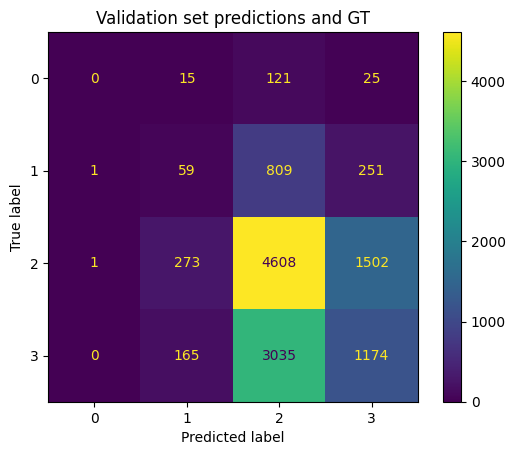

In [16]:
ConfusionMatrixDisplay.from_predictions(result_df['y_true'], result_df['y_pred'])
plt.title('Validation set predictions and GT')
plt.show()

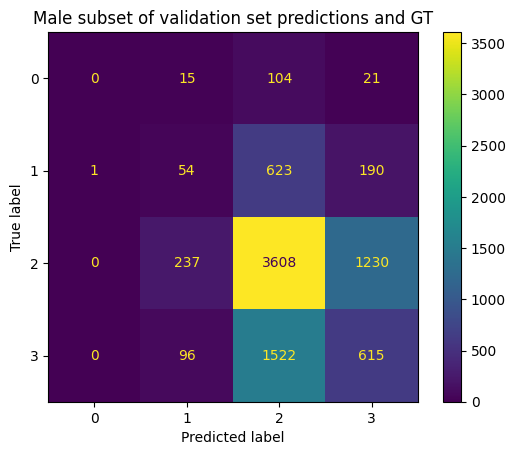

In [17]:
male_results = result_df[result_df['gender']==1]
ConfusionMatrixDisplay.from_predictions(male_results['y_true'], male_results['y_pred'])
plt.title('Male subset of validation set predictions and GT')
plt.show()

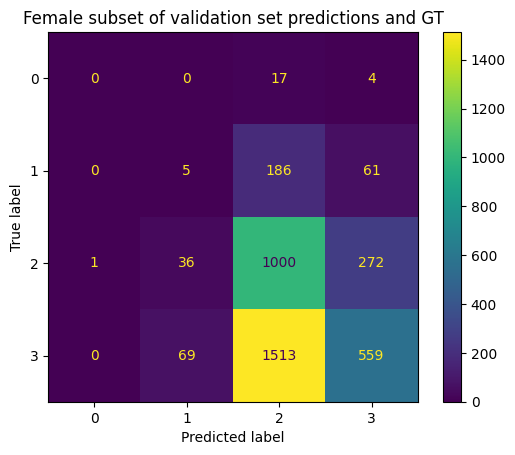

In [18]:
female_results = result_df[result_df['gender']==0]
ConfusionMatrixDisplay.from_predictions(female_results['y_true'], female_results['y_pred'])
plt.title('Female subset of validation set predictions and GT')
plt.show()

In [19]:
f1_score(
    female_results['y_true'],
    female_results['y_pred'],
    average=None
)

array([0.        , 0.02762431, 0.49689441, 0.36812644])

In [20]:
f1_score(
    male_results['y_true'],
    male_results['y_pred'],
    average=None
)

array([0.        , 0.08503937, 0.6600805 , 0.28678014])

<a class="anchor" id="section4"></a>
# Additional Charts

In [21]:
### Check distribution of predicted labels per sensitivity group

In [35]:
label_list = ['0: Very Low', '1: Low', '2: High', '3: Very High']

<function matplotlib.pyplot.show(close=None, block=None)>

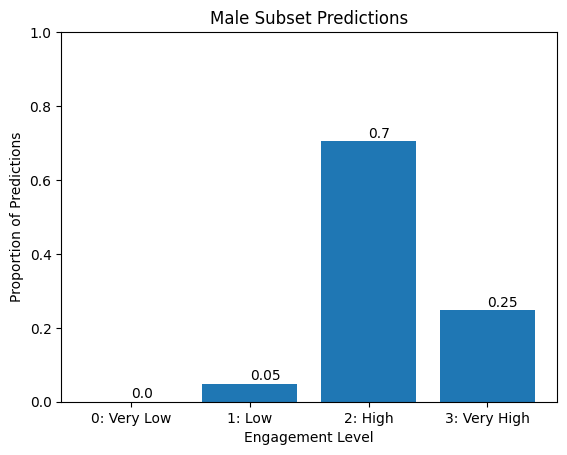

In [38]:
male_count_list = [0, 0, 0, 0]
for pred in male_results['y_pred'].value_counts().keys():
    male_count_list[pred] = male_results['y_pred'].value_counts()[pred] / sum(male_results['y_pred'].value_counts())
    
plt.title('Male Subset Predictions')

plt.bar(label_list, male_count_list, width=0.8, tick_label=label_list)

for idx, value in enumerate(male_count_list):
    plt.text(idx, value+0.01, round(value, 2))
    
plt.ylim([0, 1])
plt.xlabel('Engagement Level')
plt.ylabel('Proportion of Predictions')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

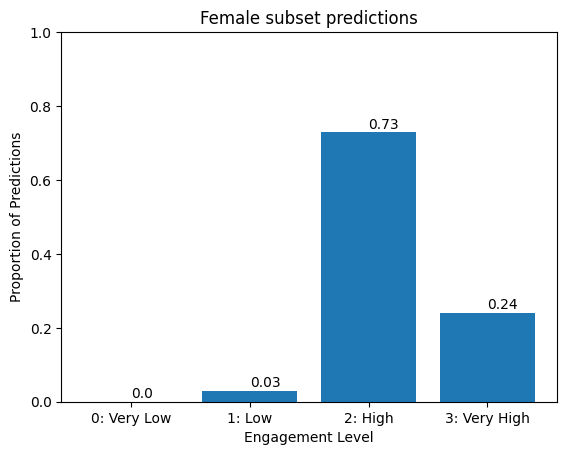

In [39]:
female_count_list = [0, 0, 0, 0]
for pred in female_results['y_pred'].value_counts().keys():
    female_count_list[pred] = female_results['y_pred'].value_counts()[pred] / sum(female_results['y_pred'].value_counts())
    
plt.title('Female subset predictions')
plt.bar([0,1,2,3], female_count_list, width=0.8, tick_label=label_list)
for idx, value in enumerate(female_count_list):
    plt.text(idx, value+0.01, round(value, 2))
    
plt.ylim([0, 1])
plt.xlabel('Engagement Level')
plt.ylabel('Proportion of Predictions')
    
plt.show